# Classification des CV avec NLP

In [1]:
import pandas as pd 
import numpy as np 
import seaborn as sns
import multiprocessing
import string
import re

from bs4 import BeautifulSoup
from gensim.models import Word2Vec
from wordcloud import WordCloud, STOPWORDS
from time import time

In [2]:
# Importation des données
data = pd.read_csv('DataSet.csv')

In [3]:
data.head()

,Category,Resume
0,Data Science,Skills * Programming Languages: Python (pandas...
1,Data Science,Education Details \r\nMay 2013 to May 2017 B.E...
2,Data Science,"Areas of Interest Deep Learning, Control Syste..."
3,Data Science,Skills â¢ R â¢ Python â¢ SAP HANA â¢ Table...
4,Data Science,"Education Details \r\n MCA YMCAUST, Faridab..."


In [4]:
print("Les différentes catégories de CV disponible:")
print(data['Category'].unique())

Les différentes catégories de CV disponible:
['Data Science' 'HR' 'Advocate' 'Arts' 'Web Designing'
 'Mechanical Engineer' 'Sales' 'Health and fitness' 'Civil Engineer'
 'Java Developer' 'Business Analyst' 'SAP Developer' 'Automation Testing'
 'Electrical Engineering' 'Operations Manager' 'Python Developer'
 'DevOps Engineer' 'Network Security Engineer' 'PMO' 'Database' 'Hadoop'
 'ETL Developer' 'DotNet Developer' 'Blockchain' 'Testing']


In [5]:
# Fonction pour nettoyer les mots
def clean(resume):
    cleaned_resume = re.sub('http\S+\s*', ' ', resume)  # remove URLs
    cleaned_resume = re.sub('RT|cc', ' ', cleaned_resume)  # remove RT and cc
    cleaned_resume = re.sub('#\S+', '', cleaned_resume)  # remove hashtags
    cleaned_resume = re.sub('@\S+', '  ', cleaned_resume)  # remove mentions
    cleaned_resume = re.sub('[%s]' % re.escape("""!"#$%&'()*+,-./:;<=>?@[\]^_`{|}~"""), ' ', cleaned_resume)  # remove punctuations
    cleaned_resume = re.sub(r'[^\x00-\x7f]',r' ', cleaned_resume) 
    cleaned_resume = re.sub('\s+', ' ', cleaned_resume)  # remove extra whitespace
    return cleaned_resume

# Chargement du tokenizer
tokenizer = nltk.data.load('tokenizers/punkt/english.pickle')

# Fonction pour obtenir une liste de mots
def make_word_list(resume, content):
    token = tokenizer.tokenize(resume.strip())
    for sentence in token:
        if len(sentence) > 0:
            words = clean(sentence)
            content.append(words)

<IPython.core.display.Javascript object>

In [6]:
# Fonction pour préparer données avant Word2Vec
def processing_to_word2vec(data):
    list_to_word2vec, final_li = [], []
    for line in data:
        cleaned = clean(line)
        make_word_list(cleaned, list_to_word2vec)
    for item in list_to_word2vec:
        words = item.lower().split(' ')
        final_li.append(words)
    return final_li

data_processed = processing_to_word2vec(data['Resume'])

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

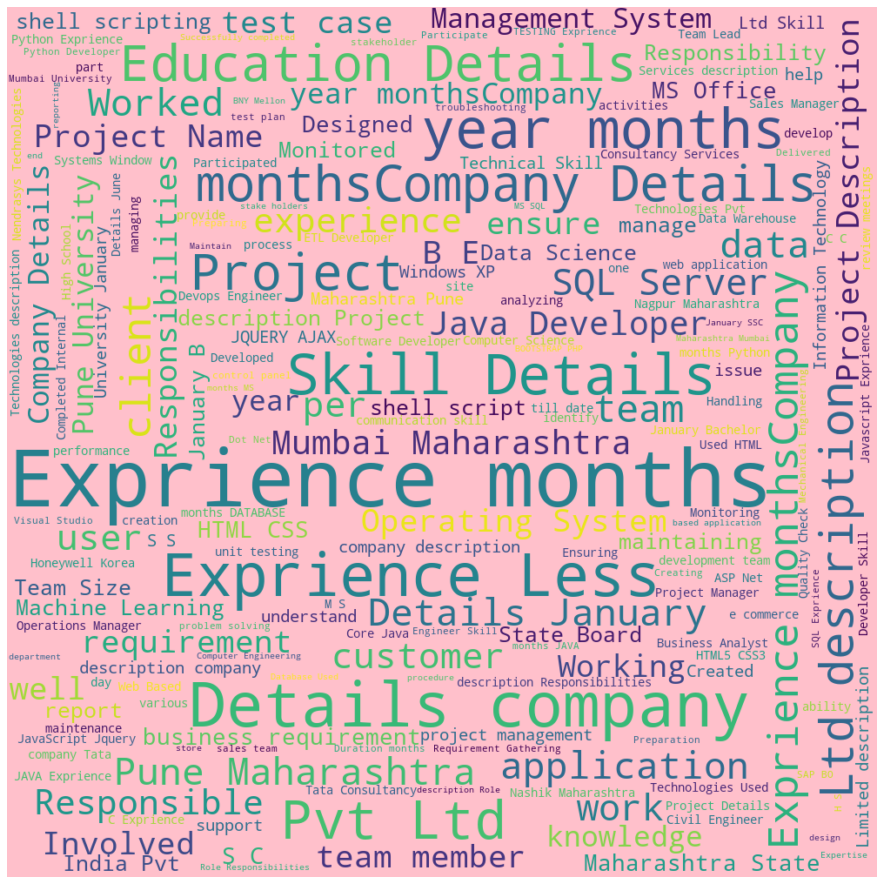

In [7]:
# Création de wordcloud
text = " ".join(resume for resume in data.Resume)
stopwords = set(STOPWORDS)
stopwords.update(["A", "À", "â", "Ã", "c c"])
wordcloud = WordCloud(stopwords=stopwords, background_color="pink", width=1000, height=1000).generate(text)

# Affichage du wordcloud
plt.figure(figsize=(16,16))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

In [8]:
# On définit le modèle
cores = multiprocessing.cpu_count()
word2vec = Word2Vec(min_count=30, window=2, size=300, sample=6e-5, alpha=0.03, min_alpha=0.0007, negative=20, workers=cores-1)

# On construit le vocabulaire
t = time()
word2vec.build_vocab(data_processed, progress_per=10000)
print(f"Temps pour construire le vocabulaire: {round((time() - t) / 60, 2)} mins")

Temps pour construire le vocabulaire: 0.01 mins


In [9]:
# On entraîne le modèle
t = time()
word2vec.train(data_processed, total_examples=word2vec.corpus_count, epochs=30, report_delay=1)

print(f"Temps pour entraîner le modèle: {round((time() - t) / 60, 2)} mins")

Temps pour entraîner le modèle: 0.13 mins


In [10]:
word2vec.wv.vectors.shape

(1925, 300)

In [11]:
word2vec.init_sims(replace=True)
word2vec.wv.save_word2vec_format('model.bin', binary=True)

In [12]:
from sklearn.cluster import KMeans
import time

start = time.time()

num_clusters = word2vec.wv.vectors.shape[0] / 5
print(f"Il y a {int(num_clusters)} clusters.")

kmeans_clustering = KMeans(n_clusters=int(num_clusters))
idx = kmeans_clustering.fit_predict(word2vec.wv.vectors)

end = time.time()
elapsed = end - start

print(f"Le clustering en KMeans à pris {round(elapsed, 3)} secondes.")

Il y a 385 clusters.
Le clustering en KMeans à pris 12.066 secondes.


In [13]:
word_centroid_map = dict(zip(word2vec.wv.index2word, idx))
word_centroid_map.values()

dict_values([131, 371, 270, 371, 270, 131, 32, 358, 204, 115, 218, 32, 204, 32, 131, 339, 146, 203, 264, 242, 377, 195, 32, 108, 118, 95, 203, 155, 121, 195, 210, 37, 203, 204, 39, 131, 203, 247, 155, 32, 61, 295, 284, 114, 3, 259, 274, 6, 177, 150, 69, 19, 204, 61, 380, 285, 209, 8, 305, 47, 37, 370, 134, 317, 135, 195, 204, 307, 218, 367, 32, 253, 367, 121, 280, 41, 69, 307, 90, 195, 135, 379, 181, 168, 114, 136, 249, 222, 83, 1, 334, 61, 377, 60, 208, 230, 52, 85, 7, 285, 218, 86, 109, 1, 60, 384, 61, 244, 110, 61, 168, 44, 368, 61, 299, 138, 102, 87, 249, 22, 166, 253, 155, 133, 231, 323, 242, 265, 75, 193, 92, 307, 349, 229, 314, 306, 26, 254, 341, 377, 384, 138, 241, 267, 217, 100, 65, 206, 1, 138, 86, 231, 4, 34, 22, 17, 52, 1, 199, 3, 1, 150, 159, 50, 2, 158, 341, 370, 289, 51, 81, 50, 316, 83, 44, 204, 116, 109, 67, 381, 64, 107, 209, 236, 45, 148, 126, 119, 241, 347, 26, 65, 358, 354, 83, 202, 83, 257, 146, 176, 266, 241, 191, 257, 218, 202, 209, 134, 349, 209, 108, 90, 295, 

In [14]:
for cluster in range(0, 10):
    print(f"\nCluster {cluster}")
    words = []
    values = list(word_centroid_map.values())
    keys = list(word_centroid_map.keys())
    for i in range(0, len(word_centroid_map.values())):
        if values[i] == cluster:
            words.append(keys[i])
    print(words)


Cluster 0
['sent', 'providers', 'stores', 'telecommunications', 'innovative']

Cluster 1
['mysql', 'used', 'html', 'javascript', 'jquery', 'css', 'ajax', 'bootstrap', 'jsp', 'php', 'servlet', 'json', 'jdbc', 'xml', 'mssql']

Cluster 2
['creating', 'automated', 'architecture', 'ci', 'package', 'fully']

Cluster 3
['engineering', 'electrical', 'diploma', 'institute', 'nashik', 'industrial', 'post', 'engg']

Cluster 4
['responsible', 'scope', 'defining', 'ordance']

Cluster 5
['type', 'manual', 'tests', 'special', 'transformers', 'temperature', 'routine', 'iec']

Cluster 6
['work', 'coordinate', 'able', 'urately', 'demand']

Cluster 7
['activities', 'implementation', 'during', 'uat', 'defect', 'enhancement', 'small']

Cluster 8
['process', 'enhance', 'suggest', 'evaluate', 'improvements', 'itil']

Cluster 9
['algorithms', 'bi', 'tableau', 'intelligence', 'visualization']


In [15]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(data["Resume"], data["Category"], test_size=0.2, random_state=42)

In [16]:
def create_bag_of_centroids(wordlist, word_centroid_map):
    num_centroids = max(word_centroid_map.values()) + 1
    bag_of_centroids = np.zeros(num_centroids, dtype="float32")
    for word in wordlist:
        if word in word_centroid_map:
            index = word_centroid_map[word]
            bag_of_centroids[index] += 1
    return bag_of_centroids

In [17]:
train_centroids = np.zeros((X_train.size, int(num_clusters)), dtype="float32")
print(train_centroids.shape)

test_centroids = np.zeros((X_test.size, int(num_clusters)), dtype="float32")
print(test_centroids.shape)

(769, 385)
(193, 385)


In [18]:
def transform_into_bag_of_centroids(centroids, data, centroid_map):
    counter = 0
    for resume in data:
        centroids[counter] = create_bag_of_centroids(resume, centroid_map)
        counter += 1

In [19]:
# Train
transform_into_bag_of_centroids(train_centroids, X_train, word_centroid_map)

# Test
transform_into_bag_of_centroids(test_centroids, X_test, word_centroid_map)

In [20]:
forest = RandomForestClassifier(n_estimators=100)

forest = forest.fit(train_centroids, y_train)
pred = forest.predict(test_centroids)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<AxesSubplot:>

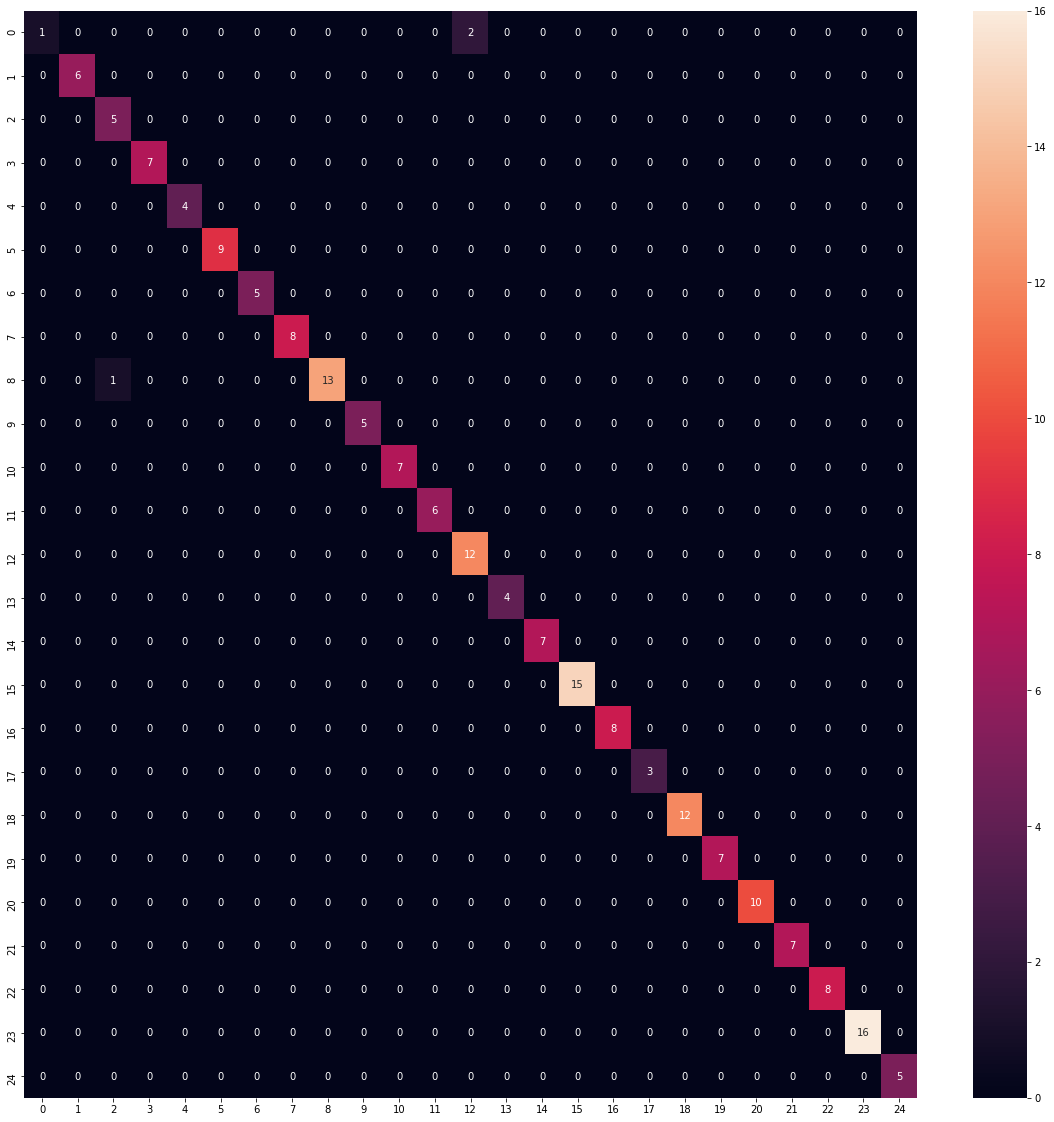

In [21]:
from sklearn.metrics import confusion_matrix

conf = confusion_matrix(y_test, pred)
plt.figure(figsize=(20,20))
sns.heatmap(conf, annot=True)